In [1]:
import sys
import json
import time
import pickle
import numpy as np
import json
import pickle

import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize

In [2]:
# Reading the data
def json_reader(fname, count=1000):
    """
        Read multiple json files
        Args:
            fname: str: input file
        Returns:
            generator: iterator over documents 
    """
    for line in open(fname, mode="r"):
        if (count <= 0):
            break
        count -= 1
        
        data = json.loads(line)
        rating = int(data['stars'])
        review = np.array(word_tokenize(data['text']))
        yield {'rating': rating, 'review': review}
        
trainset = './dataset/NB/train.json'
testset = './dataset/NB/test.json'

In [3]:
# Making of the dictionary
tick = time.time()
dictionary = {}
for data in json_reader(trainset, 10000):
    for word in data['review']:
        dictionary[word] = 0
        
dictionary = { word : idx for idx, word in enumerate(dictionary)}
print (len(dictionary))

with open('dictionary.pickle', 'wb') as handle:
    pickle.dump(dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("Time Taken: ", time.time() - tick)

40148
Time Taken:  16.59535002708435


In [4]:
# Loading the Dictionary
with open('dictionary.pickle', 'rb') as handle:
    dictionary = pickle.load(handle)

In [5]:
# Computing Phi's
Phi = np.zeros(5)

totalRatings = 0
for data in json_reader(trainset, 10000):
    totalRatings += 1
    Phi[data['rating'] - 1] += 1
    
Phi /= totalRatings
print (Phi, totalRatings)

Phi = np.log(Phi)
print (Phi)

[0.1471 0.0849 0.1114 0.2155 0.4411] 10000
[-1.91664265 -2.46628119 -2.19462795 -1.53479437 -0.81848367]


In [6]:
# Computing ThetaWK's
V = len(dictionary)
print (V)

tick = time.time()

ThetaNum = np.zeros((V, 5)) + 1
ThetaDeno = np.zeros((V, 5)) + V 

def computeFreq (doc, rating):
    k = rating - 1
    ThetaDeno[:, k] += len(doc)
    
    for word in doc:
        w = dictionary[word]
        ThetaNum[w][k] += 1
    
    return 0
    
for data in json_reader(trainset, 10000):
    computeFreq (data['review'], data['rating'])
    
Theta = np.log(ThetaNum / ThetaDeno)

np.set_printoptions(precision=2)
print (ThetaNum)
print (ThetaDeno)
print (Theta)

print ("Time Taken: ", time.time() - tick)


40148
[[1.00e+00 1.00e+00 2.00e+00 1.30e+01 3.70e+01]
 [1.42e+03 8.07e+02 1.00e+03 1.71e+03 2.49e+03]
 [2.92e+02 1.45e+02 1.47e+02 2.05e+02 3.24e+02]
 ...
 [1.00e+00 1.00e+00 2.00e+00 1.00e+00 1.00e+00]
 [1.00e+00 1.00e+00 2.00e+00 1.00e+00 1.00e+00]
 [1.00e+00 1.00e+00 2.00e+00 1.00e+00 1.00e+00]]
[[272104. 174650. 209314. 321270. 482709.]
 [272104. 174650. 209314. 321270. 482709.]
 [272104. 174650. 209314. 321270. 482709.]
 ...
 [272104. 174650. 209314. 321270. 482709.]
 [272104. 174650. 209314. 321270. 482709.]
 [272104. 174650. 209314. 321270. 482709.]]
[[-12.51 -12.07 -11.56 -10.12  -9.48]
 [ -5.26  -5.38  -5.34  -5.23  -5.27]
 [ -6.84  -7.09  -7.26  -7.36  -7.31]
 ...
 [-12.51 -12.07 -11.56 -12.68 -13.09]
 [-12.51 -12.07 -11.56 -12.68 -13.09]
 [-12.51 -12.07 -11.56 -12.68 -13.09]]
Time Taken:  18.156128406524658


In [7]:
# Predictions
def predictClass (doc):
    probs = np.zeros(5)
    for k in range(0, 5):
        probs[k] += Phi[k];
        for word in doc:
            if word not in dictionary:
                continue
            w = dictionary[word]
            probs[k] += Theta[w][k]
    return np.argmax(probs) + 1

def randomPredictions (doc):
    return np.random.randint(1, 6)
    
    
def majorityPrediction (doc):
    return 5

In [8]:
# Actual Predictions
tick = time.time()

correctPredictions = 0
totalPredictions = 0
for data in json_reader(testset, 10000):
    prediction = predictClass (data['review'])
    totalPredictions += 1
    if (prediction == data['rating']):
        correctPredictions += 1
    
print (totalPredictions)
print ("Accuracy: %.2f%%" % (correctPredictions * 100 / totalPredictions))
print ("Time Taken: ", time.time() - tick)

10000
Accuracy: 59.76%
Time Taken:  25.06342363357544


In [9]:
# Random Predictions
tick = time.time()

correctPredictions = 0
totalPredictions = 0
for data in json_reader(testset, 10000):
    prediction = randomPredictions (data['review'])
    totalPredictions += 1
    if (prediction == data['rating']):
        correctPredictions += 1
    
print (totalPredictions)
print ("Accuracy: %.2f%%" % (correctPredictions * 100 / totalPredictions))
print ("Time Taken: ", time.time() - tick)

10000
Accuracy: 19.21%
Time Taken:  15.511351823806763


In [10]:
# Majority Predictions
tick = time.time()

correctPredictions = 0
totalPredictions = 0
for data in json_reader(testset, 10000):
    prediction = majorityPrediction (data['review'])
    totalPredictions += 1
    if (prediction == data['rating']):
        correctPredictions += 1
    
print (totalPredictions)
print ("Accuracy: %.2f%%" % (correctPredictions * 100 / totalPredictions))
print ("Time Taken: ", time.time() - tick)

10000
Accuracy: 44.14%
Time Taken:  15.402688026428223


Time Taken:  26.38666033744812
Confusion matrix, without normalization
[[1193   21   48  131  135]
 [ 294   35   88  306  120]
 [ 146    9   79  639  203]
 [  84    4   28 1081  942]
 [ 171    2    6  647 3588]]
Normalized confusion matrix
[[7.81e-01 1.37e-02 3.14e-02 8.57e-02 8.84e-02]
 [3.49e-01 4.15e-02 1.04e-01 3.63e-01 1.42e-01]
 [1.36e-01 8.36e-03 7.34e-02 5.94e-01 1.89e-01]
 [3.93e-02 1.87e-03 1.31e-02 5.05e-01 4.40e-01]
 [3.87e-02 4.53e-04 1.36e-03 1.47e-01 8.13e-01]]


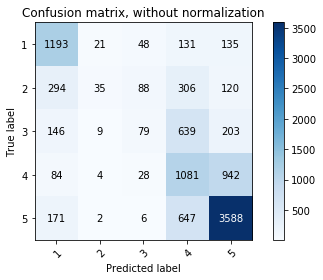

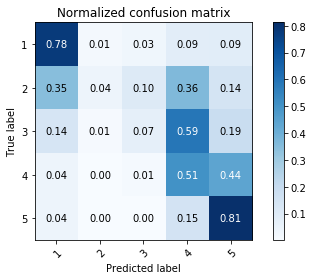

In [12]:
# Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# Confusion Matrix
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names = np.array(['1', '2', '3', '4', '5'])

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Load the training data and predictions
tick = time.time()
ratings = []
predictions = []
for data in json_reader(testset, 10000):
    prediction = predictClass (data['review'])
    ratings.append(data['rating'] - 1)
    predictions.append(prediction - 1)
ratings = np.array(ratings)
predictions = np.array(predictions)
print ("Time Taken: ", time.time() - tick)

    # Plot non-normalized confusion matrix
plot_confusion_matrix(ratings, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(ratings, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
